<a href="https://colab.research.google.com/github/tiyasadey3/GEN_AI/blob/main/FoodRecognition%26RecipeGeneratorAudio_With_langchain%26langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Step 1: Install Dependencies
%pip install --quiet torch torchvision transformers pillow langgraph langchain langchain_community langchain-openai colab-xterm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install gTTS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.1
    Uninstalling click-8.2.1:
      Successfully uninstalled click-8.2.1


In [4]:
%load_ext colabxterm
%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [5]:
# Step 2: Imports
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, END
from langchain.llms import Ollama
from PIL import Image
from google.colab import files
from IPython.display import display
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

In [6]:
import re
from gtts import gTTS
import IPython.display as ipd

Saving WhatsApp Image 2025-06-02 at 22.32.44.jpeg to WhatsApp Image 2025-06-02 at 22.32.44.jpeg


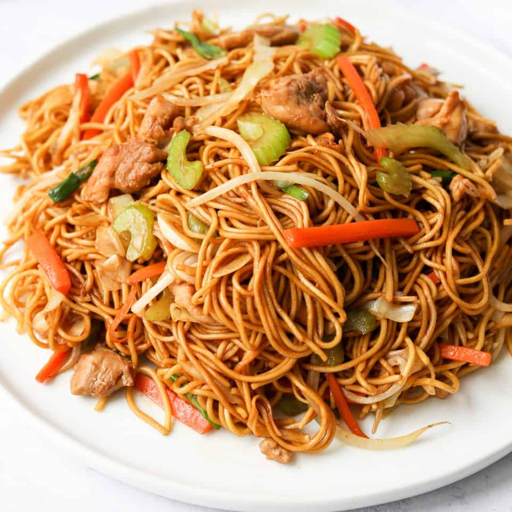

In [8]:
# Step 3: Upload Food Image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
food_image = Image.open(image_path).convert("RGB").resize((512, 512))
display(food_image)

In [16]:
# Step 4: BLIP to Describe Food
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

inputs = processor(food_image, return_tensors="pt")
with torch.no_grad():
    output = model.generate(**inputs)
    blip_description = processor.decode(output[0], skip_special_tokens=True)

print("BLIP Food Description:", blip_description)

BLIP Food Description: a plate of noodles with meat and vegetables


In [17]:
# Step 5: LLM (Ollama with LLaMA 3)
llm = Ollama(model="llama3")


In [18]:
# Step 6: Define Node Functions
def identify_dish(state):
    desc = state["description"]
    prompt = f"Identify the dish from this description: '{desc}'. Be specific and include the origin."
    result = llm.invoke(prompt)
    state["dish_identified"] = result
    return state

def generate_recipe(state):
    dish = state["dish_identified"]
    prompt = f"Create a detailed recipe for the dish: '{dish}'. Include ingredients and instructions."
    result = llm.invoke(prompt)
    state["recipe"] = result
    return state

def healthify_recipe(state):
    dish = state["dish_identified"]
    prompt = f"Suggest a healthier version of the dish: '{dish}'. Give nutritional advice and substitutions."
    result = llm.invoke(prompt)
    state["healthy_version"] = result
    return state

In [19]:
# Step 7: Build LangGraph Workflow
from typing import TypedDict

# Define the state schema for the graph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        description: Description of the food from BLIP.
        dish_identified: The identified dish from the LLM.
        recipe: The generated recipe for the dish.
        healthy_version: Suggestions for a healthier version of the dish.
    """
    description: str
    dish_identified: str
    recipe: str
    healthy_version: str

workflow = StateGraph(GraphState)

workflow.add_node("identify_dish", RunnableLambda(identify_dish))
workflow.add_node("generate_recipe", RunnableLambda(generate_recipe))
workflow.add_node("healthify_recipe", RunnableLambda(healthify_recipe))

# Define Edges
workflow.set_entry_point("identify_dish")
workflow.add_edge("identify_dish", "generate_recipe")
workflow.add_edge("generate_recipe", "healthify_recipe")
workflow.add_edge("healthify_recipe", END)

In [20]:
# Step 8: Compile and Run
graph = workflow.compile()

initial_state = {
    "description": blip_description
}

final_state = graph.invoke(initial_state)


In [21]:
# Step 9: Output
print("\n Identified Dish:\n", final_state["dish_identified"])
print("\n Recipe:\n", final_state["recipe"])
print("\n Healthier Version:\n", final_state["healthy_version"])


 Identified Dish:
 A simple yet delicious description!

Based on your description, I'm going to take a guess that the dish is... **Chow Mein**!

Chow Mein is a popular Chinese stir-fry noodle dish that originated in Southern China and was later introduced to the United States by Chinese immigrants in the early 20th century. It typically consists of noodles, meat (usually beef or chicken), and vegetables (such as bell peppers, carrots, and bean sprouts) cooked together in a savory sauce.

Is my guess correct?

 Recipe:
 You're absolutely right! The dish I was thinking of is indeed Chow Mein!

Here's a simple yet delicious recipe to make this popular Chinese dish:

**Ingredients:**

* 1 pound beef or chicken, sliced into thin strips
* 2 tablespoons vegetable oil
* 1 onion, thinly sliced
* 2 cloves garlic, minced
* 1 cup mixed vegetables (such as bean sprouts, carrots, and bell peppers)
* 1 cup cooked noodles (preferably Chow Mein noodles or lo mein noodles)
* 2 tablespoons soy sauce
* 2

In [22]:
# Step 10: Convert Recipe to Speech
# Clean the recipe text to remove non-alphabetic characters except common punctuation
raw_recipe = final_state["recipe"]
cleaned_recipe = re.sub(r'[^a-zA-Z0-9.,!?\'\n ]+', '', raw_recipe)

# Text-to-speech on cleaned recipe
tts = gTTS(cleaned_recipe)
tts.save("recipe_audio.mp3")
ipd.display(ipd.Audio("recipe_audio.mp3"))